# Goal

To find 3 datasets that exhibit some behaviour that has some trend

In [1]:
import os
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [4]:
class IATParser:
    def __init__(self, folder_path, save_path):
        self.scaler = MinMaxScaler()
        self.folder_path = folder_path
        self.save_path = save_path

    def aggregate_IAT(self):  # Aggregate all biflows in this JSON file
        all_iat_data = []

        # List all files in the folder
        files = os.listdir(self.folder_path)

        # Filter out the JSON files
        json_files = [f for f in files if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(self.folder_path, file_name)
            with open(file_path, 'r') as f:
                biflow_data = json.load(f)

            for currentBiflow, biflow_data in biflow_data.items():
                biflowPacketData = biflow_data['packet_data']
                print()
                biflowIAT = biflowPacketData['iat']  # Extract interarrival times

                # Append interarrival times to the list
                all_iat_data.extend(biflowIAT)

            # Create a DataFrame from aggregated interarrival times
            iat_df = pd.DataFrame({'Interarrival': all_iat_data})

        return iat_df

    def get_99(self, df):
        return df["Interarrival"].quantile(0.99)

    def saturate_99(self, df, percentile_val):  # Saturating to the 99th percentile
        df['Interarrival'] = df['Interarrival'].apply(
            lambda x: min(x, percentile_val))

        return df

    def minmax_scaler(self, df):  # Apply min-max scaler to the dataset
        df['Interarrival_scaled'] = self.scaler.fit_transform(
            df[['Interarrival']])

        return df

    def get_minmax_scaler(self):
        return self.scaler
    
    def generate_debug_set_from_folder(self, min_iat_count=2000):
        '''
        Processes all JSON files in a folder and returns a list of DataFrames with interarrival times (IAT)
        from all biflow dictionaries that have at least `min_iat_count` IATs.

        Parameters:
        folder_path (str): Path to the folder containing JSON files.
        min_iat_count (int): Minimum number of interarrival times required.

        Returns:
        list: List of DataFrames, each containing interarrival times from a qualifying biflow.
        '''
        all_bf = self.aggregate_IAT()
        percentile_val = self.get_99(all_bf)

        biflow_dataframes = []

        # List all files in the folder
        files = os.listdir(self.folder_path)

        # Filter out the JSON files
        json_files = [f for f in files if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(self.folder_path, file_name)
            with open(file_path, 'r') as f:
                biflow_data = json.load(f)

                for currentBiflow, biflow in biflow_data.items():
                    biflowPacketData = biflow['packet_data']
                    # Extract interarrival times
                    biflowIAT = biflowPacketData['iat']

                    # Add qualifying biflows to the list of DataFrames
                    if len(biflowIAT) >= min_iat_count and len(biflowIAT) <= 5000:
                        biflow_df = pd.DataFrame({'Interarrival': biflowIAT})
                        biflow_df = self.saturate_99(biflow_df, percentile_val)
                        biflow_df = self.minmax_scaler(biflow_df)
                        
                        biflow_df['L4_payload'] = np.add(
                            biflowPacketData['L4_payload_bytes'], biflowPacketData['L4_header_bytes'])

                        biflow_dataframes.append(biflow_df)

                        # Save the DataFrame as a CSV file if save_path is provided
                        if self.save_path:
                            csv_file = os.path.join(
                                self.save_path, f'biflow_{len(biflow_dataframes)}.csv')
                            biflow_df.to_csv(csv_file, index=False)

        return biflow_dataframes

In [5]:
# Usage
# Replace with your folder path
folder_path = r'..\data\MIRAGE\MIRAGE-COVID-CCMA-2022\Raw_JSON\Teams\Teams'
save_path = r"C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes_L4"
parser = IATParser(folder_path, save_path)
biflow_dataframes = parser.generate_debug_set_from_folder()

# Check the result
if biflow_dataframes:
    for i, df in enumerate(biflow_dataframes):
        print(f"Biflow {i+1}:\n", df.head())
else:
    print("No qualifying biflows found.")

print(biflow_dataframes)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_biflow_dataframes(biflow_dataframes, plot_path=None):
    '''
    Plots interarrival times (IAT) against packet index for each biflow DataFrame in the list.
    
    Parameters:
    biflow_dataframes (list): List of DataFrames, each containing interarrival times from a qualifying biflow.
    plot_path (str, optional): Path to the folder to save plots. If None, plots are displayed instead of saved.
    '''

    for i, df in enumerate(biflow_dataframes):
        plt.figure(figsize=(10, 6))
        plt.plot(df.index, df['Interarrival'],
                 marker='o', linestyle='-', markersize=3)
        plt.title(f'Biflow {i+1} Interarrival Times')
        plt.xlabel('Packet Index')
        plt.ylabel('Interarrival Time')

        if plot_path:
            plot_file = os.path.join(
                plot_path, f'biflow_{i+1}_interarrival_times.png')
            plt.savefig(plot_file)
            plt.close()
        else:
            plt.show()

# Usage
# Replace with your desired plot save path or set to None to display
plot_path = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\data_plots_L4'
plot_biflow_dataframes(biflow_dataframes, plot_path)

In [25]:
csv_file1 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes_L4\biflow_15.csv'

l4_df = pd.read_csv(csv_file1)

total_payload_bytes = l4_df['L4_payload'].sum()
total_time = l4_df['Interarrival'].sum()

l4_df['L4_payload_cumsum'] = l4_df['L4_payload'].cumsum()
l4_df['Interarrival_cumsum'] = l4_df['Interarrival'].cumsum()
rate = total_payload_bytes/total_time

print(l4_df)
print("total_payload_bytes: ", total_payload_bytes)
print("total_time: ", total_time)
print("transmission rate: ", rate)
print("Minimum IAT: ", l4_df[l4_df['Interarrival'] > 0.0].min(axis=0))
print("Biggest packet: ", l4_df['L4_payload'].max(axis=0))
print("Max assumed rate: ", (l4_df['L4_payload'].max(axis=0)/rate))
print("End of packet: ", 0.059188 + (88/rate))

      Interarrival  Interarrival_scaled  L4_payload  L4_payload_cumsum  \
0         0.000000             0.000000         120                120   
1         0.059188             0.195710          88                208   
2         0.000999             0.003303         112                320   
3         0.047813             0.158098          96                416   
4         0.002001             0.006616         124                540   
...            ...                  ...         ...                ...   
2652      0.222000             0.734063         112             499442   
2653      0.001002             0.003313         151             499593   
2654      0.042001             0.138880          95             499688   
2655      0.019703             0.065150          80             499768   
2656      0.302426             1.000000          91             499859   

      Interarrival_cumsum  
0                0.000000  
1                0.059188  
2                0.060187  

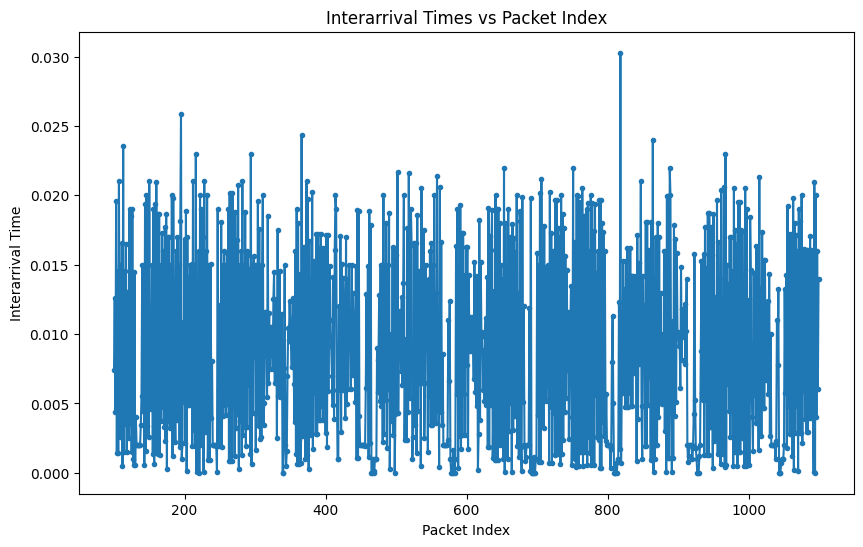

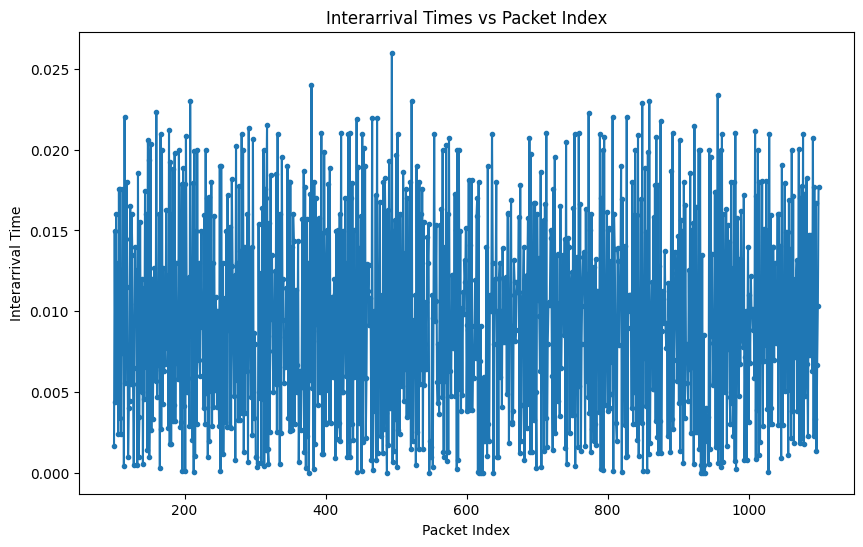

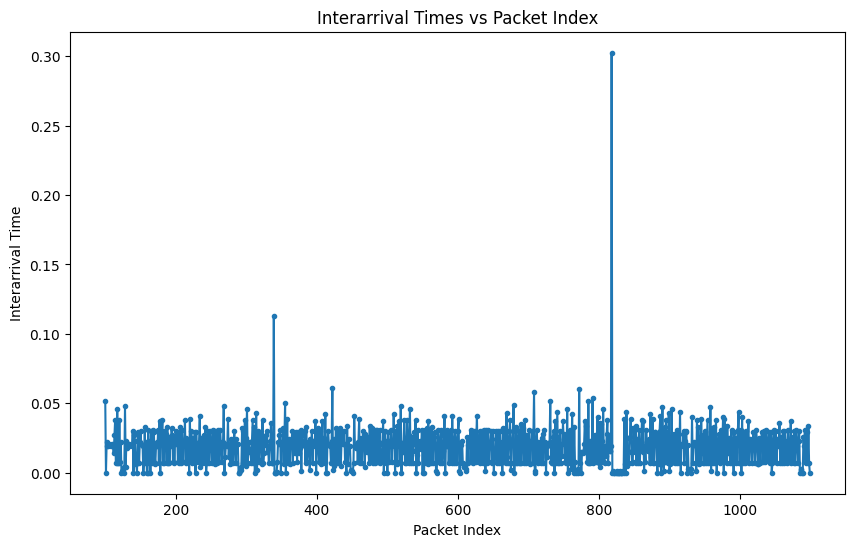

In [ ]:
# Reading biflows 15, 67, 77
def read_csv_to_dataframe(csv_file):
    '''
    Reads a CSV file into a Pandas DataFrame.

    Parameters:
    csv_file (str): Path to the CSV file.

    Returns:
    pd.DataFrame: DataFrame containing the data from the CSV file.
    '''
    return pd.read_csv(csv_file)


def plot_iat_vs_index(df, title='Interarrival Times vs Packet Index', plot_path=None):
    '''
    Plots interarrival times (IAT) against packet index.

    Parameters:
    df (pd.DataFrame): DataFrame containing interarrival times.
    title (str): Title of the plot.
    plot_path (str, optional): Path to save the plot. If None, the plot is displayed.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Interarrival'],
             marker='o', linestyle='-', markersize=3)
    plt.title(title)
    plt.xlabel('Packet Index')
    plt.ylabel('Interarrival Time')

    # if plot_path:
    #     plt.savefig(plot_path)
    #     plt.close()
    # else:
    #     plt.show()


# Example usage
# Replace with your CSV file path
csv_file1 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes\biflow_15.csv'
csv_file2 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes\biflow_67.csv'
csv_file3 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes\biflow_77.csv'
# Replace with your desired plot save path or set to None to display
# plot_path = 'path/to/save/plot.png'

# Read the CSV file into a DataFrame
df1 = read_csv_to_dataframe(csv_file1)
df2 = read_csv_to_dataframe(csv_file2)
df3 = read_csv_to_dataframe(csv_file3)

# Plot the IAT against packet index
plot_iat_vs_index(df1[100:1100], plot_path=plot_path)
plot_iat_vs_index(df2[100:1100], plot_path=plot_path)
plot_iat_vs_index(df3[100:1100], plot_path=plot_path)